In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import PIL.Image as Image
from IPython.display import display
import time
from torchvision import datasets, transforms, models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir='/content/drive/MyDrive/ColabNotebooks/cardir'
train_dir = '/content/drive/MyDrive/ColabNotebooks/cardir/train'
valid_dir = '/content/drive/MyDrive/ColabNotebooks/cardir/valid'
test_dir ='/content/drive/MyDrive/ColabNotebooks/cardir/test'

In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size =32,shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 20, shuffle = True)

In [ ]:
model = models.vgg19(pretrained=True)

In [ ]:
def nn_setup(dropout=0.5, hidden_layer1 = 120,lr = 0.001):

    model = models.vgg19(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

        from collections import OrderedDict
        dropout = 0.5  # or whatever value you want to use for dropout
        classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(dropout)),
                          ('fc2', nn.Linear(4096, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(dropout)),
                          ('fc3', nn.Linear(4096, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(dropout)),
                          ('fc4', nn.Linear(500, 196)),
                          ('output', nn.LogSoftmax(dim=1))
                        ]))


        model.classifier = classifier
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.classifier.parameters(), lr )


        return model , optimizer ,criterion

In [ ]:
model,optimizer,criterion = nn_setup('vgg19')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 236MB/s]


In [ ]:
# Use gpu mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0

    # change model to work with cuda
    model.to(device)

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):

        # Change images and labels to work with cuda
        images, labels = images.to(device), labels.to(device)

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)

        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, accuracy

In [ ]:
epochs = 8
steps = 0
print_every = 40
model.train()
for e in range(epochs):

    running_loss = 0
    train_accuracy=0
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        # zeroing parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(outputs)
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()

            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)

            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Training Accuracy: {round(float(train_accuracy/print_every),3)}\
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")

            running_loss = 0

            # Turning training back on
            model.train()



No. epochs: 1,             Training Loss: 7.413             Training Accuracy: 0.003            Valid Loss: 5.345             Valid Accuracy: 0.005
No. epochs: 1,             Training Loss: 5.398             Training Accuracy: 0.005            Valid Loss: 5.347             Valid Accuracy: 0.003
No. epochs: 1,             Training Loss: 5.314             Training Accuracy: 0.011            Valid Loss: 5.293             Valid Accuracy: 0.006
No. epochs: 1,             Training Loss: 5.32             Training Accuracy: 0.017            Valid Loss: 5.284             Valid Accuracy: 0.004
No. epochs: 1,             Training Loss: 5.344             Training Accuracy: 0.021            Valid Loss: 5.275             Valid Accuracy: 0.006
No. epochs: 2,             Training Loss: 2.003             Training Accuracy: 0.002            Valid Loss: 5.275             Valid Accuracy: 0.005
No. epochs: 2,             Training Loss: 5.311             Training Accuracy: 0.009            Valid Loss: 5.277

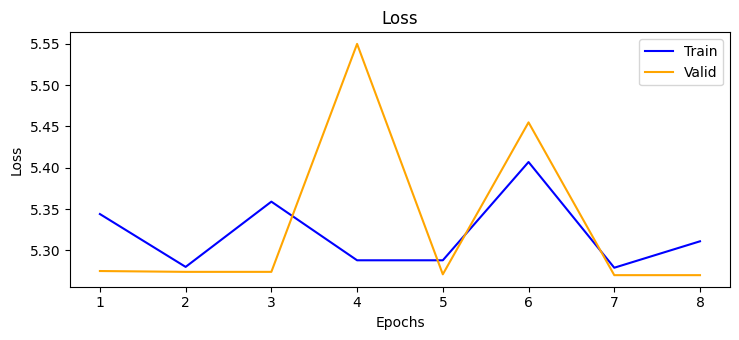

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x=np.array([1,2,3,4,5,6,7,8])
Train = np.array([5.344, 5.28, 5.359, 5.288, 5.288, 5.407, 5.279, 5.311])
Valid = np.array([5.275, 5.274, 5.274, 5.55, 5.271, 5.455, 5.27, 5.27])

ax1 = plt.subplot()
l1, = ax1.plot(x, Train, color='Blue')
l2, = ax1.plot(x, Valid, color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
plt.legend([l1, l2], ["Train", "Valid"])
plt.title("Loss")
plt.show()

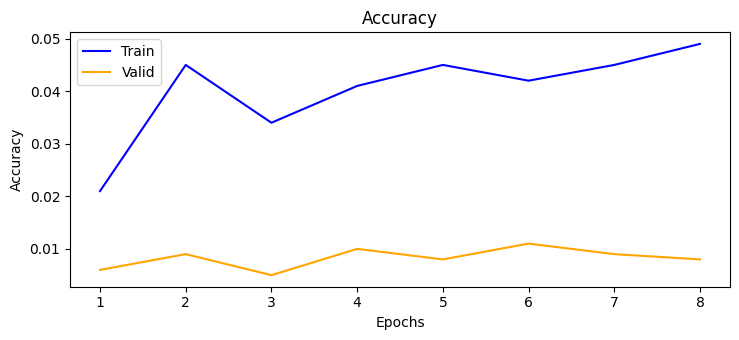

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x=np.array([1,2,3,4,5,6,7,8])
Train = np.array([0.021, .045, .034, .041, .045, .042, .045, .049])
Valid = np.array([.006, .009, .005, .01, .008, .011, .009, .008])

ax1 = plt.subplot()
l1, = ax1.plot(x, Train, color='Blue')
l2, = ax1.plot(x, Valid, color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
plt.legend([l1, l2], ["Train", "Valid"])
plt.title("Accuracy")
plt.show()

In [ ]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 0.833%


In [ ]:
checkpoint = {'state_dict': model.state_dict(),
              'classifier': model.classifier,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/MyDrive/ColabNotebooks/my_VGG19checkpoint.pth')

In [ ]:
model = load_checkpoint('/content/drive/MyDrive/ColabNotebooks/my_VGG19checkpoint.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)

    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']

    return model


In [ ]:
def process_image(image):

    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

    # Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd


In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

In [ ]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file

    # Loading model
    loaded_model = load_checkpoint(model)
    # Moving the loaded model to the GPU
    loaded_model.cuda()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Moving the input tensor to the GPU
    img_tensor = img_tensor.cuda()
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)
    input=Variable(img_add_dim)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]

    # Converting probabilities and outputs to lists
    conf = np.array(probs_top.cpu())[0]
    predicted = np.array(predicted_top.cpu())[0]

    return conf, predicted



In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(train_dir)

print(classes, c_to_idx)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

In [ ]:
def plot_solution(cardir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/MyDrive/ColabNotebooks/my_VGG19checkpoint.pth'
  image_path = test_dir+cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):

      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path+'.jpg')


  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis()

  plt.show()

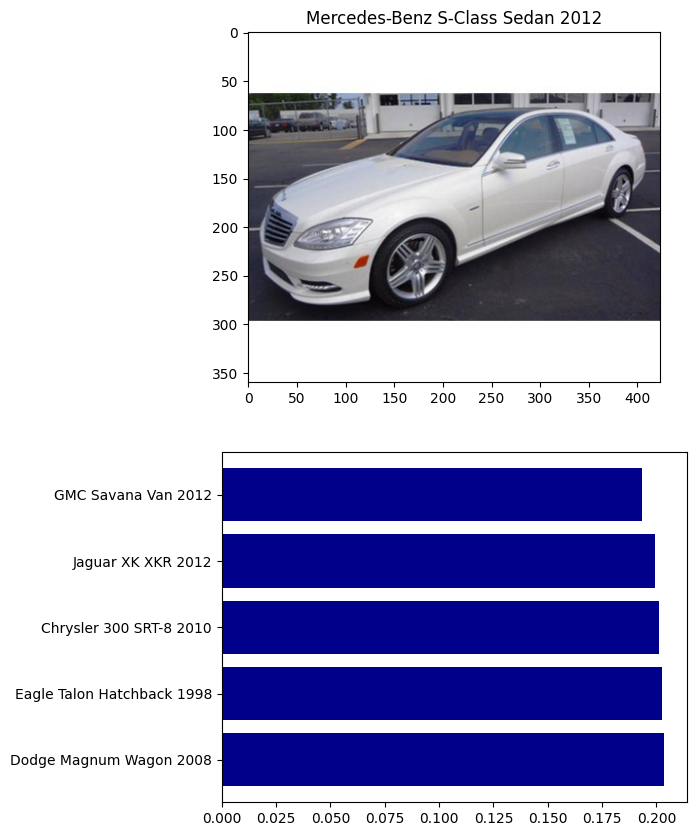

In [ ]:
cardir='/Mercedes-Benz S-Class Sedan 2012/06543'
plot_solution(cardir , model)

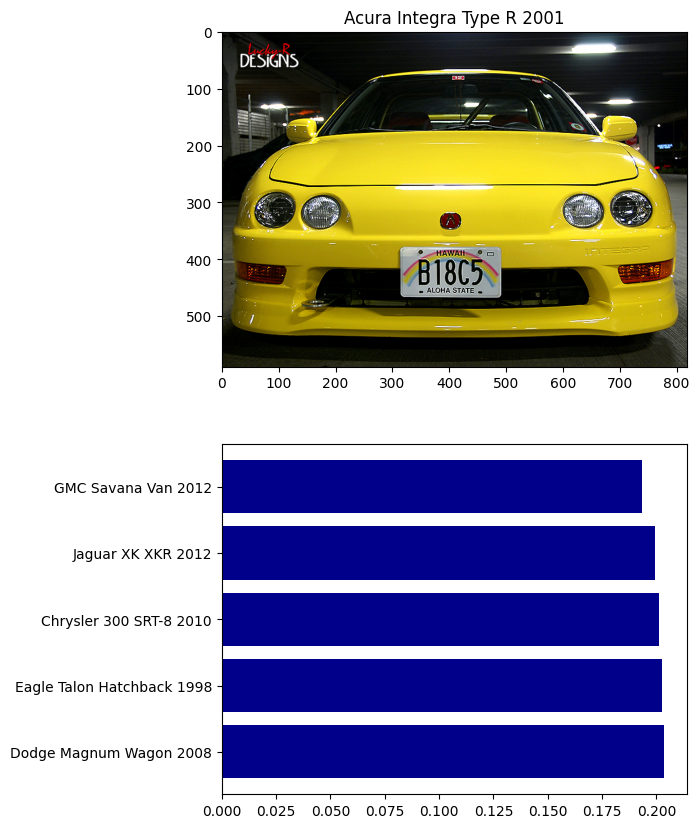

In [ ]:
cardir='/Acura Integra Type R 2001/06181'
plot_solution(cardir , model)

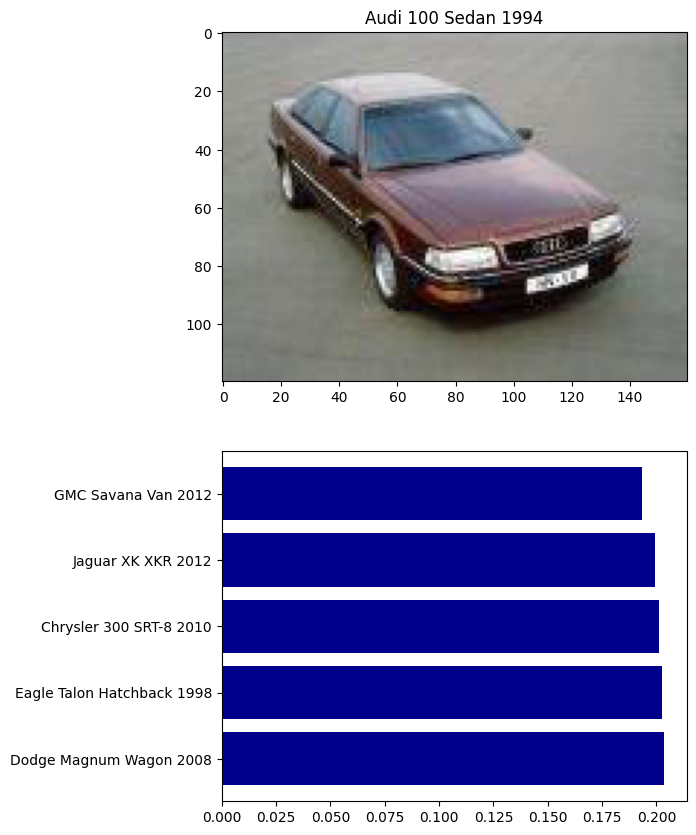

In [ ]:
cardir='/Audi 100 Sedan 1994/00082'
plot_solution(cardir , model)